Source - https://github.com/LukasJur/technical_analysis_indicators_python/blob/master/aroon_ulcer.py

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# from mplfinance import candlestick_ohlc
from mplfinance.original_flavor import candlestick_ohlc
 
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import datetime
import time

In [2]:
def get_date_indexed_pd(filename):
    format = '%m/%d/%Y'
    data_pd = pd.read_csv(filename)
    data_pd['Date'] = pd.to_datetime(data_pd['Date'], format=format)
    data_pd = data_pd.set_index(data_pd['Date'])
    return data_pd.drop(columns=['Date'])

In [3]:
def format_ohlc(dataframe):
    dates = mdates.date2num(dataframe.index)
    ohlc = []
    for x in range(len(dataframe)):
        #              Time         Open            High                     Low                Close
        append_me = dates[x], dataframe.iat[x, 1], dataframe.iat[x, 2], dataframe.iat[x, 3], dataframe.iat[x, 4]
        ohlc.append(append_me)
    return ohlc

In [4]:
def calc_ulcer_index(filepath, column_name='UlcerIndex', periods=14):
    # Returns a dataframe read from filepath with ulcer index as an added column
    # Ulcer Index formula:
    # 1) Percentage Drawdown = [(Close - N-period High Close)/N-period High Close] x 100
    # 2) Squared Average = (N-period Sum of Percent-Drawdown Squared)/N
    # 3) Ulcer Index = Square Root of Squared Average
    security = get_date_indexed_pd(filepath)
    period_high_close = security['Close'].rolling(periods + 1).apply(lambda x: np.amax(x), raw=True)
    percentage_drawdown = security['Close']
    percentage_drawdown = (percentage_drawdown - period_high_close)/period_high_close * 100
    percentage_drawdown = np.clip(percentage_drawdown, a_min=None, a_max=0)
    percentage_drawdown = percentage_drawdown ** 2
    percentage_drawdown = percentage_drawdown.fillna(0)
    period_sum = percentage_drawdown.rolling(periods+1).sum()
    squared_average = round((period_sum / periods), 2)
    ulcer_index = round(squared_average ** 0.5, 2)
    security[column_name] = ulcer_index
    return security

In [5]:
def plot_ulcer(dataframe, col_name, graph_title, indic_title):
    # Plot a graph with two subplots, one containing ohlc of a security
    # the other - indicator taken from dataframe column provided by col_name
    fig, ax = plt.subplots(2, 1, sharex=True, sharey=False)
    ohlc = format_ohlc(dataframe)
    candlestick_ohlc(ax[0], ohlc)
    ax[1].plot(dataframe[col_name])
    ax[0].set_title(graph_title)
    ax[0].set_ylabel('Price, USD')
    ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax[0].xaxis.set_major_locator(mticker.MaxNLocator(8))
    ax[0].grid()
    ax[1].set_title(indic_title)
    ax[1].yaxis.set_major_locator(mticker.MaxNLocator(12))
    ax[1].set_xlabel('Date')
    ax[1].grid()
    fig.show()

In [6]:
def calc_aroon_indicator(filepath, col_name, periods = 25):
    # Returns a dataframe read from filepath with aroon indicator put in columns from col_name
    # col_name - 2 element list, where the first element is the name for aroon up column,
    # and the second is the name for aroon down column
    # Aroon Up = ( N - Nhc) / N * 100
    # Aroon Down = ( N - Nlc) / N * 100
    # where N - periods provided by the function,
    # Nhc, Nlc - periods since N-period high and periods since N-period low respectively
    security = get_date_indexed_pd(filepath)
    aroon_up = security['High'].rolling(periods+1).apply(lambda x: x.argmax(), raw=True) / periods * 100
    aroon_down = security['Low'].rolling(periods+1).apply(lambda x: x.argmin(), raw=True) / periods * 100
    security[col_name[0]] = aroon_up
    security[col_name[1]] = aroon_down
    return security

In [7]:
def plot_aroon(dataframe, col_name, graph_title, subtitle='Aroon Indicator'):
    fig, ax = plt.subplots(2, 1, sharex=True, sharey=False)
    ohlc = format_ohlc(dataframe)
    candlestick_ohlc(ax[0], ohlc)
    ax[1].plot(dataframe[col_name])
    ax[0].set_title(graph_title)
    ax[0].set_ylabel('Price, USD')
    ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax[0].xaxis.set_major_locator(mticker.MaxNLocator(8))
    ax[0].grid()
    ax[1].set_title(subtitle)
    ax[1].yaxis.set_major_locator(mticker.MaxNLocator(12))
    ax[1].set_xlabel('Date')
    ax[1].grid()
    fig.show()

In [8]:
def calc_aroon_osc(dataframe, col_name=['Aroon_Up', 'Aroon_Dn'], periods=14, osc_name='Aroon_Osc'):
    aroon_osc = dataframe[col_name]
    aroon_osc[osc_name] = aroon_osc[col_name[0]] - aroon_osc[col_name[1]]
    dataframe[osc_name] = aroon_osc[osc_name]
    return aroon_osc

C:\Users\DELL\AppData\Local\Temp\ipykernel_11632\3662259465.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


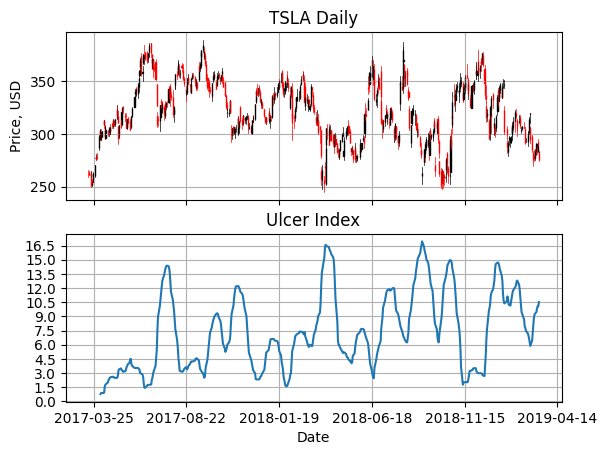

In [11]:
#### EXAMPLE USAGE
#       ULCER INDEX
col_name = 'UlcerIndex'
# filepath = 'put your filepath here'

# Example 1
TSLA = calc_ulcer_index('TSLA.txt')
plot_ulcer(TSLA, col_name, 'TSLA Daily','Ulcer Index')